## Load State and Action data

In [105]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [106]:
# We load the logged state and scheduling actions from the default scheduler
states = pd.read_csv("../data/states.csv")
actions = pd.read_csv("../data/actions.csv")

# We convert some units
# Some unity conversion

states["node_cpu_total"] = states["node_cpu_total_milli"] / 1000.0
states["pod_cpu_request"] = states["pod_cpu_request_milli"] / 1000.0
states["pod_ram_request_mib"] = states["pod_ram_request_mib"] / (1024.0 * 1024.0)

# Datetime conversion
states["timestamp"] = pd.to_datetime(states["timestamp"])
actions["timestamp"] = pd.to_datetime(actions["timestamp"])

In [107]:
actions.head()

,timestamp,pod_name,chosen_node_name
0,2025-05-31 14:54:07.555752709+00:00,workload-6924,cloud-7
1,2025-05-31 14:54:07.671938305+00:00,workload-8868,cloud-6
2,2025-05-31 14:54:07.773946227+00:00,workload-7539,cloud-5
3,2025-05-31 14:54:07.900168788+00:00,workload-4565,cloud-3
4,2025-05-31 14:54:08.025001287+00:00,workload-594,cloud-6


In [108]:
states.head()

,timestamp,pod_name,pod_cpu_request_milli,pod_ram_request_mib,candidate_node_name,node_cpu_total_milli,node_ram_total_mib,node_cpu_model_energy_val,node_type,energy_before,energy_after,node_cpu_total,pod_cpu_request
0,2025-05-31 14:54:07.535977633+00:00,workload-6924,6000,3072.0,cloud-1,8000,16384,169.5159,cloud,225.5013,582.9039,8.0,6.0
1,2025-05-31 14:54:07.536603485+00:00,workload-6924,6000,3072.0,cloud-2,10000,24576,179.1791,cloud,223.5013,546.4454,10.0,6.0
2,2025-05-31 14:54:07.538592719+00:00,workload-6924,6000,3072.0,cloud-6,24000,61440,179.1791,cloud,214.5013,389.1925,24.0,6.0
3,2025-05-31 14:54:07.539086571+00:00,workload-6924,6000,3072.0,cloud-8,8000,40960,166.3510,cloud,200.5013,590.9039,8.0,6.0
4,2025-05-31 14:54:07.540654240+00:00,workload-6924,6000,3072.0,cloud-4,6000,49152,166.3510,cloud,226.5013,729.9514,6.0,6.0


In [ ]:

# Assuming these constants are defined elsewhere or passed in
UNSCHEDULABLE_PENALTY = -1000.0 # Example penalty

def encode_node_type(node_type_str: str) -> float:
    if node_type_str == 'edge':
        return 1.0
    elif node_type_str == 'cloud':
        return 2.0
    else: # unknown or other
        return 0.0
    
def get_bonus_coeff(node_type_str: str) -> float:
    if node_type_str == 'edge':
        return 0.6 # Example bonus coefficient for edge nodes
    else:
        return 1.0

# This method builds (s_t, r_t, s_{t+1}, done) tuples
# s_t: features of (pod + chosen_node_before_placement)
# r_t: reward for choosing that node for that pod
# s_{t+1}: features representing the state after the action (simplified for offline)
# done: boolean, true if terminal (e.g., unschedulable)
# def build_transitions(state_df: pd.DataFrame, action_df: pd.DataFrame, unschedulable_penalty=UNSCHEDULABLE_PENALTY):
#     transitions = []

#     # --- 1. Process successfully scheduled pods (actions taken) ---
#     # For each action (chosen pod-node pair), find the corresponding detailed state from state_df.
#     # This state_df entry represents the 'state-action' pair that was chosen.
#     for _, action_row in action_df.iterrows():
#         pod_name = action_row['pod_name']
#         chosen_node_name = action_row['chosen_node_name']
#         action_timestamp = action_row['timestamp'] # Use datetime version

#         # Find the specific row in state_df that matches this pod, chosen_node,
#         # and is the closest state evaluation *before or at* the action time.
#         # This assumes 'state.csv' logs the evaluation of (pod, chosen_node)
#         # which includes 'energy_before' and 'energy_after' for that specific choice.
        
#         # Filter state_df for the specific pod and the node it was CHOSEN for
#         matching_state_entries = state_df[
#             (state_df['pod_name'] == pod_name) 
#         ]

#         if matching_state_entries.empty:
#             print(f"Warning: No matching state_df entry found for chosen action: Pod '{pod_name}' on Node '{chosen_node_name}' around {action_timestamp}. Skipping.")
#             continue
        
#         # Select the state entry closest in time (usually the last one before/at action)
#         # This ensures we get the state evaluation specific to this decision for this node.
#         chosen_node_state_details = matching_state_entries.sort_values(by='timestamp', ascending=False).iloc[0]

#         # s_t: Features for the (pod + chosen_node_before_placement)
#         # This IS the state representation for the action "place pod on chosen_node_name"
#         s_t = np.array([
#             chosen_node_state_details['pod_cpu_request_milli'],
#             chosen_node_state_details['pod_ram_request_mib'],
#             chosen_node_state_details['node_cpu_total_milli'],
#             chosen_node_state_details['node_ram_total_mib'],
#             chosen_node_state_details['node_cpu_model_energy_val'],
#             encode_node_type(chosen_node_state_details['node_type']),
#             chosen_node_state_details['energy_before'] # Energy if this pod is placed on this chosen node
#         ], dtype=np.float32)

#         # r_t: Reward based on the 'energy_after' for this CHOSEN action
#         r_t = -float(chosen_node_state_details['energy_after']) * get_bonus_coeff(chosen_node_state_details['node_type'])

#         # s_{t+1}: Simplified next state, representing the chosen node *after* placement.
#         # The Q-target will estimate the value of this resulting state.
#         s_next = np.array([
#             0.0,  # Placeholder for next pod's CPU
#             0.0,  # Placeholder for next pod's RAM
#             chosen_node_state_details['node_cpu_total_milli'],
#             chosen_node_state_details['node_ram_total_mib'],
#             chosen_node_state_details['node_cpu_model_energy_val'],
#             encode_node_type(chosen_node_state_details['node_type']),
#             chosen_node_state_details['energy_after'] # Energy of this node *after* current pod
#         ], dtype=np.float32)

#         done = False
#         # Store the pod_name and chosen_node_name with the transition for later reference or debugging
#         transitions.append((s_t, r_t, s_next, done, pod_name, chosen_node_name))


#     # --- 2. Process unschedulable pods ---
#     all_pods_evaluated = set(state_df['pod_name'].unique())
#     scheduled_pods = set(action_df['pod_name'].unique())
#     unschedulable_pod_names = all_pods_evaluated - scheduled_pods

#     for pod_name_unsched in unschedulable_pod_names:
#         # This pod was evaluated (has entries in state_df) but never got an action_df entry.
#         # We need a representative state for this failure.
#         # Let's pick the state of the *first node it was evaluated on* during its last failed attempt.
#         pod_state_entries = state_df[state_df['pod_name'] == pod_name_unsched].sort_values(by='timestamp_dt')
        
#         if pod_state_entries.empty: # Should not happen if it was in all_pods_evaluated
#             continue

#         # Take the first evaluated state for this unschedulable pod as the representative s_t
#         first_eval_entry = pod_state_entries.iloc[0]

#         s_t_unsched = np.array([
#             first_eval_entry['pod_cpu_request_milli'],
#             first_eval_entry['pod_ram_request_mib'],
#             first_eval_entry['node_cpu_total_milli'],
#             first_eval_entry['node_ram_total_mib'],
#             first_eval_entry['node_cpu_model_energy_val'],
#             encode_node_type(first_eval_entry['node_type']),
#             first_eval_entry['energy_before'] # Energy if pod placed on this (first-evaluated) node
#         ], dtype=np.float32)

#         r_t_unsched = unschedulable_penalty

#         s_next_unsched = np.zeros_like(s_t_unsched, dtype=np.float32) # Terminal state
#         done_unsched = True

#         transitions.append((s_t_unsched, r_t_unsched, s_next_unsched, done_unsched, pod_name_unsched, "UNSCHEDULABLE"))
        
#     return transitions




In [119]:
def build_transitions(state_df: pd.DataFrame, action_df: pd.DataFrame, unschedulable_penalty=UNSCHEDULABLE_PENALTY):
    """
    Build transitions using ALL state evaluations, not just chosen actions.
    Each (pod, candidate_node) pair becomes a potential state-action with appropriate labeling.
    """
    transitions = []
    
    # Create a mapping of pod_name -> chosen_node_name for quick lookup
    action_map = dict(zip(action_df['pod_name'], action_df['chosen_node_name']))
    
    # Group state_df by pod_name to process all candidate nodes for each pod
    for pod_name, pod_group in state_df.groupby('pod_name'):
        
        # Check if this pod was successfully scheduled
        if pod_name in action_map:
            chosen_node = action_map[pod_name]
            
            # Process each candidate node evaluation for this pod
            for _, state_row in pod_group.iterrows():
                candidate_node = state_row['candidate_node_name']
                
                # Build state representation for this (pod, candidate_node) pair
                s_t = np.array([
                    state_row['pod_cpu_request_milli'],
                    state_row['pod_ram_request_mib'], 
                    state_row['node_cpu_total_milli'],
                    state_row['node_ram_total_mib'],
                    state_row['node_cpu_model_energy_val'],
                    encode_node_type(state_row['node_type']),
                    state_row['energy_before']
                ], dtype=np.float32)
                
                # Determine if this candidate node was the chosen action
                if candidate_node == chosen_node:
                    # This was the CHOSEN action - use actual energy_after as basis for reward
                    r_t = -float(state_row['energy_after']) * get_bonus_coeff(state_row['node_type'])
                    
                    # Next state represents the node after placement
                    s_next = np.array([
                        0.0,  # Placeholder for next pod's CPU
                        0.0,  # Placeholder for next pod's RAM  
                        state_row['node_cpu_total_milli'],
                        state_row['node_ram_total_mib'],
                        state_row['node_cpu_model_energy_val'],
                        encode_node_type(state_row['node_type']),
                        state_row['energy_after']
                    ], dtype=np.float32)
                    
                    done = False
                    action_label = "CHOSEN"
                    
                else:
                    # This was a NON-CHOSEN action - use energy_after as counterfactual reward
                    # This represents "what would have happened if we chose this node instead"
                    r_t = -float(state_row['energy_after']) * get_bonus_coeff(state_row['node_type'])
                    
                    # Next state represents what the node would look like after placement
                    s_next = np.array([
                        0.0,  # Placeholder for next pod's CPU
                        0.0,  # Placeholder for next pod's RAM
                        state_row['node_cpu_total_milli'], 
                        state_row['node_ram_total_mib'],
                        state_row['node_cpu_model_energy_val'],
                        encode_node_type(state_row['node_type']),
                        state_row['energy_after']  # Counterfactual energy after placement
                    ], dtype=np.float32)
                    
                    done = False
                    action_label = "NOT_CHOSEN"
                
                # Store transition with additional metadata
                transitions.append((s_t, r_t, s_next, done, pod_name, candidate_node, action_label))
        
        else:
            # Pod was unschedulable - all its candidate evaluations are negative examples
            for _, state_row in pod_group.iterrows():
                candidate_node = state_row['candidate_node_name']
                
                s_t_unsched = np.array([
                    state_row['pod_cpu_request_milli'],
                    state_row['pod_ram_request_mib'],
                    state_row['node_cpu_total_milli'], 
                    state_row['node_ram_total_mib'],
                    state_row['node_cpu_model_energy_val'],
                    encode_node_type(state_row['node_type']),
                    state_row['energy_before']
                ], dtype=np.float32)
                
                r_t_unsched = unschedulable_penalty
                s_next_unsched = np.zeros_like(s_t_unsched, dtype=np.float32)  # Terminal state
                done_unsched = True
                
                transitions.append((s_t_unsched, r_t_unsched, s_next_unsched, done_unsched, 
                                 pod_name, candidate_node, "UNSCHEDULABLE"))
    
    print(f"Generated {len(transitions)} transitions from {len(state_df)} state evaluations")
    print(f"Breakdown:")
    chosen_count = sum(1 for t in transitions if t[6] == "CHOSEN")
    not_chosen_count = sum(1 for t in transitions if t[6] == "NOT_CHOSEN") 
    unschedulable_count = sum(1 for t in transitions if t[6] == "UNSCHEDULABLE")
    print(f"  - CHOSEN actions: {chosen_count}")
    print(f"  - NOT_CHOSEN actions: {not_chosen_count}")
    print(f"  - UNSCHEDULABLE actions: {unschedulable_count}")
    
    return transitions


def create_weighted_experience_replay_buffer(transitions, chosen_weight=1.0, not_chosen_weight=0.3, unschedulable_weight=1.0):
    """
    Create a weighted sampling strategy for the experience replay buffer.
    This helps balance the training since NOT_CHOSEN actions are much more numerous.
    """
    weighted_transitions = []
    
    for transition in transitions:
        action_label = transition[6]  # 7th element is the action label
        
        if action_label == "CHOSEN":
            weight = chosen_weight
        elif action_label == "NOT_CHOSEN": 
            weight = not_chosen_weight
        else:  # UNSCHEDULABLE
            weight = unschedulable_weight
            
        weighted_transitions.append((transition, weight))
    
    return weighted_transitions

In [118]:
transitions = build_transitions(states, actions)


print(f"Total transitions built: {len(transitions)}")

Total transitions built: 49


## Build and train DQN

DQN are essentially a feed forward network that takes in states as input and return the Q-values as an output that we will use to make an action: decide on which node to place the current pod.

We will build the simple DQN network with PyTorch

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import pickle
from sklearn.preprocessing import StandardScaler # For feature scaling


In [99]:
# Define some constants and hyperparameters
BATCH_SIZE = 16
GAMMA = 0.7       # Discount factor
TAU = 0.005       # Target network update rate
LR = 1e-5         # Learning rate
NUM_TRAINING_STEPS = 50000 # Or epochs over data
PRINT_EVERY_N_STEPS = 500
N_OBSERVATIONS = 7 # pod_cpu, pod_ram, node_cpu, node_ram, node_model_energy, node_type, energy_before

## Setting seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [100]:
# --- DQN Model ---
class DQN(nn.Module):
    def __init__(self, n_observations):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1) # Outputs a single Q-value

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


We now implemenet the training loop that will take the transition matrix that we built earlier from the state and the actions log to train the model, we will need to perform some extra pre-processing to fit the data into PyTorch eco-system as below

In [102]:
SCALER_SAVE_PATH = "../models/scaler.pkl"
MODEL_SAVE_PATH = "../models/dqn_model.pth"


state_df = states.copy()
action_df = actions.copy()

transitions = build_transitions(state_df, action_df)

if not transitions:
    print("No transitions were built. Check your log data and preprocessing logic.")
    exit()

print(f"Built {len(transitions)} transitions.")

# 2. Feature Scaling: Quite important for PyTorch training stability
all_states_for_scaling = np.array([t[0] for t in transitions])
scaler = StandardScaler()
scaler.fit(all_states_for_scaling) # Fit on all s_t

# Save the scaler
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Feature scaler saved to {SCALER_SAVE_PATH}")

# Apply scaling to all states in transitions
scaled_transitions = []
for s_t, r_t, s_next, done in transitions:
    s_t_scaled = scaler.transform(s_t.reshape(1, -1))[0] # Reshape for single sample
    s_next_scaled = scaler.transform(s_next.reshape(1, -1))[0] if not done else np.zeros_like(s_t) # Scale s_next if not terminal
    scaled_transitions.append((s_t_scaled, r_t, s_next_scaled, done))

transitions = scaled_transitions # Use scaled transitions for training


Built 49 transitions.
Feature scaler saved to ../models/scaler.pkl


After scaling the transition matrix, we can now proceed to the training loop logic by init the network weights and the optimizer (Adam), we use L1 smooth loss as the criterion.

To train the DQN we take a batch of the state $s_t$, a batch for the reward $r_t$ and a batch for the next state $s_{t+1}$.

In [103]:
# 3. Initialize Networks and Optimizer
policy_net = DQN(N_OBSERVATIONS).to(device)
target_net = DQN(N_OBSERVATIONS).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()

# Initialize lists to track losses and steps for plotting later
losses = []
steps = []

# MIN Loss will help us save model with the best performance
min_loss = float('inf')

# 4. Training Loop
for step in range(NUM_TRAINING_STEPS):
    if len(transitions) < BATCH_SIZE:
        batch_samples = random.sample(transitions, len(transitions)) if len(transitions) > 0 else []
    else:
        batch_samples = random.sample(transitions, BATCH_SIZE)

    if not batch_samples:
        # print(f"Step {step+1}/{NUM_TRAINING_STEPS}: No samples in batch. Skipping.")
        continue

    states_b = np.array([s[0] for s in batch_samples])
    rewards_b = np.array([s[1] for s in batch_samples])
    next_states_b = np.array([s[2] for s in batch_samples])
    dones_b = np.array([s[3] for s in batch_samples])

    s_tens = torch.tensor(states_b, device=device, dtype=torch.float32)
    r_tens = torch.tensor(rewards_b, device=device, dtype=torch.float32).unsqueeze(1)
    s_next_tens = torch.tensor(next_states_b, device=device, dtype=torch.float32)
    d_tens = torch.tensor(dones_b, device=device, dtype=torch.float32).unsqueeze(1)

    curr_q = policy_net(s_tens)

    next_q_target_net = torch.zeros(len(batch_samples), 1, device=device)
    non_final_mask = (d_tens == 0).squeeze()

    if non_final_mask.any().item(): # Check if any non_final states exist
        non_final_s_next = s_next_tens[non_final_mask]
        if non_final_s_next.numel() > 0: # Check if tensor is not empty
            with torch.no_grad():
                next_q_target_net[non_final_mask] = target_net(non_final_s_next)
    
    expected_q = r_tens + (GAMMA * next_q_target_net * (1.0 - d_tens))
    loss = criterion(curr_q, expected_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Soft update target network
    target_sd = target_net.state_dict()
    policy_sd = policy_net.state_dict()
    for key in policy_sd:
        target_sd[key] = policy_sd[key]*TAU + target_sd[key]*(1-TAU)
    target_net.load_state_dict(target_sd)

    if (step + 1) % PRINT_EVERY_N_STEPS == 0:
        losses.append(loss.item())
        steps.append(step + 1)
        print(f"Step: {step+1}/{NUM_TRAINING_STEPS}, Loss: {loss.item():.4f}")
        if loss.item() < min_loss:
            min_loss = loss.item()
            # Save the model with the best performance
            torch.save(policy_net.state_dict(), MODEL_SAVE_PATH)
            print(f"New best model saved at step {step + 1} with loss {min_loss:.4f}")

Step: 500/50000, Loss: 366.6218
New best model saved at step 500 with loss 366.6218
Step: 1000/50000, Loss: 416.3119
Step: 1500/50000, Loss: 426.2938
Step: 2000/50000, Loss: 411.5637
Step: 2500/50000, Loss: 356.4390
New best model saved at step 2500 with loss 356.4390
Step: 3000/50000, Loss: 418.5283
Step: 3500/50000, Loss: 423.8528
Step: 4000/50000, Loss: 401.4599
Step: 4500/50000, Loss: 419.6387
Step: 5000/50000, Loss: 382.9888
Step: 5500/50000, Loss: 416.7099
Step: 6000/50000, Loss: 349.1950
New best model saved at step 6000 with loss 349.1950
Step: 6500/50000, Loss: 389.1078
Step: 7000/50000, Loss: 433.0632
Step: 7500/50000, Loss: 405.4121
Step: 8000/50000, Loss: 377.1290
Step: 8500/50000, Loss: 392.0075
Step: 9000/50000, Loss: 366.7822
Step: 9500/50000, Loss: 390.2995
Step: 10000/50000, Loss: 420.7806
Step: 10500/50000, Loss: 379.8227
Step: 11000/50000, Loss: 374.7465
Step: 11500/50000, Loss: 371.1855
Step: 12000/50000, Loss: 397.4228
Step: 12500/50000, Loss: 384.3730
Step: 13000/

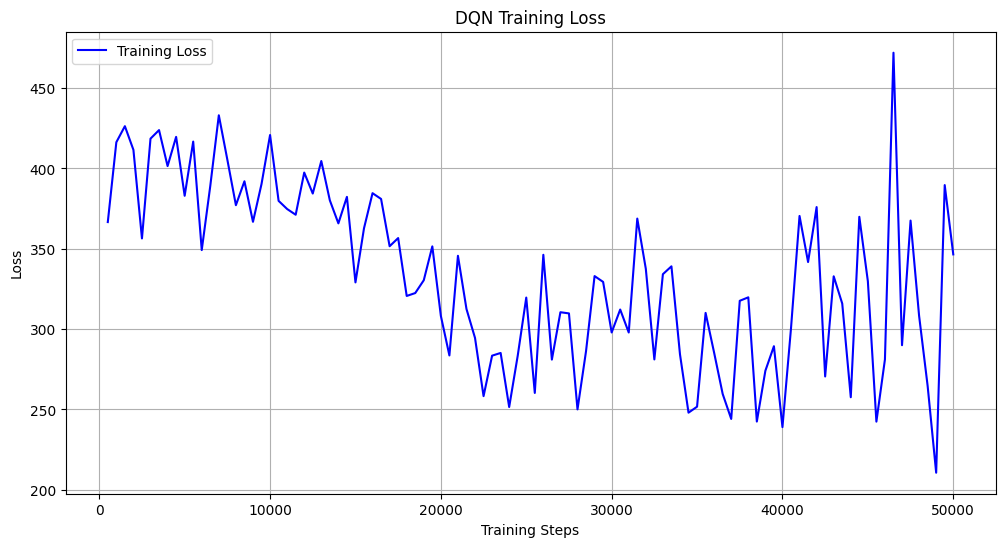

In [104]:
# Plot the training loss over steps
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(steps, losses, label='Training Loss', color='blue')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('DQN Training Loss')
plt.legend()
plt.grid()
plt.savefig("../img/dqn_training_loss.png")

## Inference and test

In [93]:
# --- 7. Inference/Testing Section ---
print("\n--- Inference/Testing Phase ---")

test_set = build_transitions(state_df, action_df)
try:
    # Load the best model for inference
    inference_model = DQN(N_OBSERVATIONS).to(device)
    inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    inference_model.eval() # Set to evaluation mode

    # Load the scaler used during training
    with open(SCALER_SAVE_PATH, 'rb') as f:
        loaded_scaler = pickle.load(f)
    print(f"Loaded scaler from {SCALER_SAVE_PATH}")

    # Test on a few samples from the original (unscaled) raw_transitions
    # Or you could load a separate test dataset if you have one
    num_test_samples = min(10, len(test_set))
    if num_test_samples == 0:
        print("No raw transitions available to test.")
    else:
        print(f"\nPredicting Q-values for {num_test_samples} sample states:")
        # Select some diverse samples if possible, or just the first few
        test_samples_raw = test_set[:num_test_samples]

        for i, (s_t_raw, r_t_raw, s_next_raw, done_raw, chosen_node_raw, pod_name_raw) in enumerate(test_samples_raw):
            # Scale the raw state s_t_raw just like during training
            s_t_scaled_for_test = loaded_scaler.transform(s_t_raw.reshape(1, -1))[0]
            state_tensor = torch.tensor(s_t_scaled_for_test, device=device, dtype=torch.float32).unsqueeze(0) # Add batch dim

            with torch.no_grad():
                predicted_q_value = inference_model(state_tensor).item()
            
            print(f"\nSample {i+1}: Pod '{pod_name_raw}', (Original) Chosen Node '{chosen_node_raw}'")
            print(f"  Raw State (s_t): {np.round(s_t_raw, 2)}")
            print(f"  Scaled State (s_t): {np.round(s_t_scaled_for_test, 2)}")
            print(f"  Predicted Q-value (Score): {predicted_q_value:.4f}")
            print(f"  Actual Reward from log (r_t): {r_t_raw:.4f}")
            if done_raw:
                print("  This was an UNSCHEDULABLE event (terminal state).")
            
            # You could also calculate the expected Q-value using the raw_reward and raw_next_state
            # to see how close the prediction is, but this requires also predicting Q for s_next_raw.
            if not done_raw:
                s_next_scaled_for_test = loaded_scaler.transform(s_next_raw.reshape(1, -1))[0]
                next_state_tensor = torch.tensor(s_next_scaled_for_test, device=device, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    predicted_next_q_value_target = target_net(next_state_tensor).item() # Use target_net for V(s')
                empirical_target_q = r_t_raw + GAMMA * predicted_next_q_value_target
                print(f"  Empirical Target Q (r + gamma*V_target(s')): {empirical_target_q:.4f} (using loaded target_net for V(s'))")


except FileNotFoundError:
    print(f"Error: Could not load model '{MODEL_SAVE_PATH}' or scaler '{SCALER_SAVE_PATH}' for testing.")
except Exception as e:
    print(f"An error occurred during the inference/testing phase: {e}")


--- Inference/Testing Phase ---
Loaded scaler from ../models/scaler.pkl

Predicting Q-values for 10 sample states:
An error occurred during the inference/testing phase: not enough values to unpack (expected 6, got 4)
